# InceptionV3 with ImageNet Weights (Transfer Learning)

In this notebook, we will be performing a preliminary investigation in using an InceptionV3 model with ImageNet weights.

# Setup:

## Connect to Remote Compute Environment

First ensure we are connected to the correct VSCode Remote Kernel. This step is important, because in order to perform the k-fold cross-validation, we need fairly powerful compute resources. 

In [1]:
!uname -nv && ls /

n9amcqolgk #138~18.04.1-Ubuntu SMP Fri Jun 24 14:14:03 UTC 2022
bin	  dev	lib    libx32  notebooks  root	srv	 tmp
boot	  etc	lib32  media   opt	  run	storage  usr
datasets  home	lib64  mnt     proc	  sbin	sys	 var


## Upgrade Python Modules

Install the latest version of Tensorflow, and install Tensorflow

In [2]:
!pip3 install --quiet --upgrade tensorflow==2.11.0
!pip3 install --quiet tensorflow_addons

Note: If you had to upgrade tensorflow to `2.11.0`, then you must restart your Jupyter notebook kernel in order for the latest version of tensorflow to be used.

## Python Environment Checks

Instantiate Python Kernel and load Python modules.

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Attempt to dynamic GPU memory (vram) allocation
try:
    tf.config.experimental.set_memory_growth(
        tf.config.list_physical_devices('GPU')[0],
        enable=True
    )
except IndexError as e:
    print("No GPU detected. Dynamic GPU vRAM allocation failed.")
    
import tensorflow_addons as tfa
import keras
from keras import layers
from typing import Literal, Union, TypeVar

# Import utility functions defined in ../common/ package
import sys
sys.path.append('../')
from common import *

2023-03-31 20:35:11.117890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 20:35:11.922172: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2023-03-31 20:35:11.922263: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2023-03-31 20:35:11.922273: W tensorflow/compiler/tf2tensorrt/utils/py_utils

Double-check GPU is available.

In [4]:
display(tf.__version__)
display(tf.config.list_physical_devices('GPU'))
display(tf.test.gpu_device_name())
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], enable=True)

'2.11.0'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

'/device:GPU:0'

# Model Preparation

Begin preparing the model's execution environment. First, we start by defining some constants:



In [5]:
BATCH_SIZE: int = 128
EPOCHS    : int = 50
IMG_SIZE  : tuple[int, int] = (299, 299)
AUTOTUNE  : Literal = tf.data.AUTOTUNE
RNG_SEED  : int = 1337

dataset_directory: str = "./"

## Prepare Datasets

Train, Test, and Validation dataset split:

* Total: 2936 (100%)
    * Train: 2055 (70%)
    * Valid:  440 (15%)
    * Test :  441 (15%)

We will also consider implementing K-fold validation in the future.

In [14]:
# InceptionV3 requires image tensors with a shape of (299, 299, 3) 
ds_train: tf.data.Dataset = tf.data.Dataset.load(dataset_directory + "ds_train")
ds_valid: tf.data.Dataset = tf.data.Dataset.load(dataset_directory + "ds_valid")
ds_test : tf.data.Dataset = tf.data.Dataset.load(dataset_directory + "ds_test")

# For K-Fold Cross Validation
ds_train_and_valid: tf.data.Dataset = ds_train.concatenate(ds_test)

In [15]:
# Batching, caching, and performance optimisations are *not* performed at this stage
# Since we are doing K-Fold validation

# configure_for_performance(ds_train)
# configure_for_performance(ds_valid)
# configure_for_performance(ds_test)

2023-03-31 20:35:19.070968: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


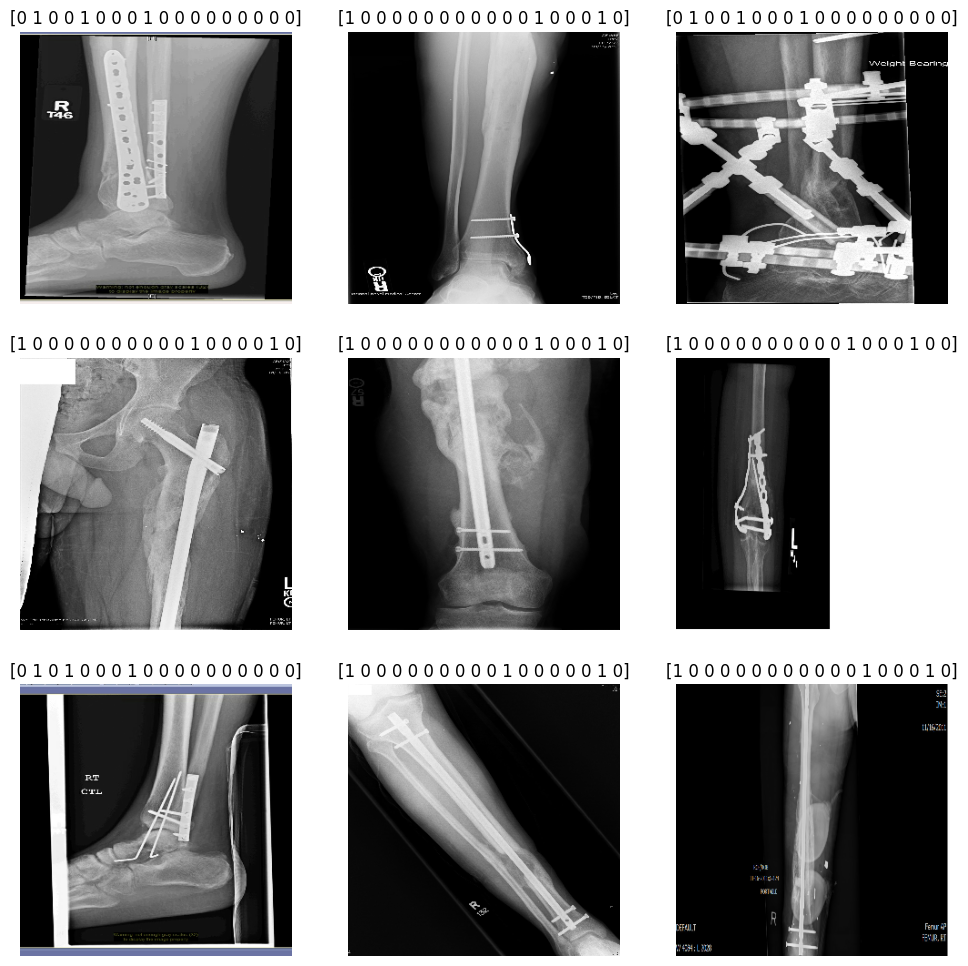

In [16]:
preview_dataset(ds_train_and_valid)

# Define Model

# Train Model with K-Fold Cross-Validation

In [18]:
kfold_history: list[dict[str, float]] = cross_validate(
    TransferLearningModel,
    ds_train_and_valid,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    k=10
)

Training fold 1/10: ds_train: 18, ds_valid: 2
87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/50
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
18/18 [==============================] - 31s 979ms/step - loss: 0.4266 - auc: 0.5741 - precision: 0.5073 - recall: 0.2642 - f1_score: 0.1050 - val_loss: 0.3449 - val_auc: 0.7062 - val_precision: 0.7719 - val_recall: 0.2938 - val_f1_score: 0.0971
Epoch 2/50
18/18 [==============================] - 2s 114ms/step - loss: 0.3122 - auc: 0.7447 - precision: 0.7837 - recall: 0.3177 - f1_score: 0.1325 - val_loss: 0.3173 - val_auc: 0.7440 - val_precision: 0.7943 - val_recall: 0.3242 - val_f1_score: 0.1211
Epoch 3/50
18/18 [==============================] - 2s 114ms/step - loss: 0.2856 - auc: 0.8058 - precision: 0.7909 - recall: 0.3599 - f1_score: 0.1965 - val_loss: 0.3077 - val

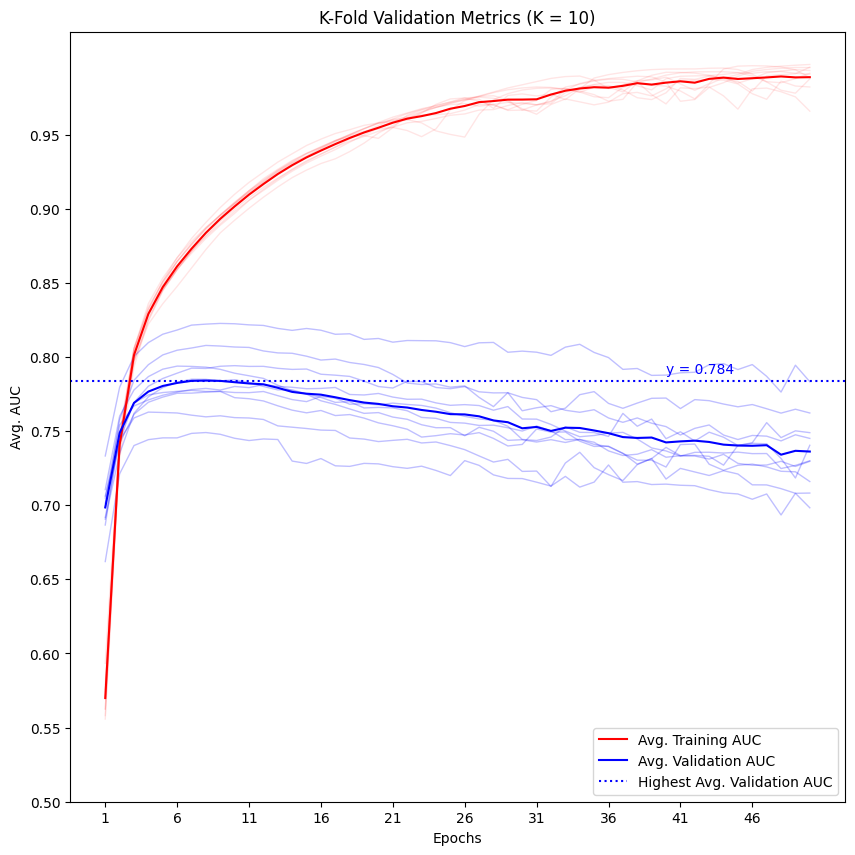

In [45]:
plot_kfold_history(kfold_history)

In [25]:
import pickle

with open('kfold_history_inceptionv3_imagenet.pickle', 'wb') as handle:
    pickle.dump(kfold_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('kfold_history_inceptionv3_imagenet.pickle', 'rb') as handle:
#     b = pickle.load(handle)